A model is said to be "well-calibrated" if the sigmoid/softmax outputs of the model align accurately with actual probability of the object belonging to a certain class.

Different models have different levels of calibration "out of the box". Let's see a few

In [199]:
from sklearn.datasets import make_classification


n_samples = 10000

X, y = make_classification(n_samples=n_samples, n_features=10, n_informative=8, n_redundant=2, random_state=42)

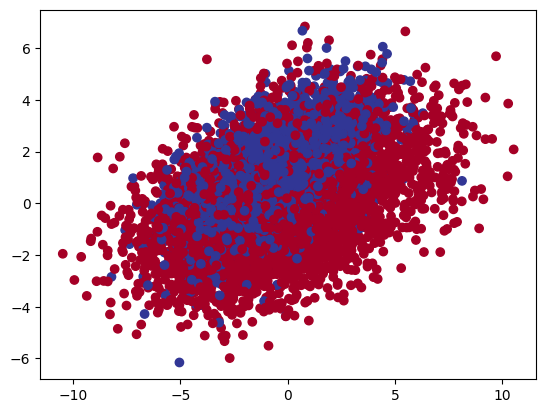

In [200]:
# Visualize with a plot
import matplotlib.pyplot as plt
import matplotlib

plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=matplotlib.colormaps["RdYlBu"])

In [201]:
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [202]:
import numpy as np

In [203]:
from sklearn.linear_model import LogisticRegression

def build_logistic_regression_model(X_train: np.ndarray, y_train: np.ndarray) -> LogisticRegression:
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

In [204]:
from sklearn.ensemble import RandomForestClassifier
def build_random_forest_model(X_train: np.ndarray, y_train: np.ndarray) -> RandomForestClassifier:
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

In [205]:
from xgboost import XGBClassifier
def build_xgboost_model(X_train: np.ndarray, y_train: np.ndarray) -> XGBClassifier:
    model = XGBClassifier(eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    return model

In [206]:
import torch
import torch.nn as nn

def build_pytorch_model(X_train: np.ndarray, y_train: np.ndarray) -> nn.Module:
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 8),  
        nn.ReLU(),                       
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, 1)                
    )
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # Training loop
    for epoch in range(100):  # 100 epochs
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor).squeeze()  # Forward pass
        loss = criterion(outputs, y_train_tensor)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    return model

def torch_predict(model: nn.Module, X_test: np.ndarray) -> np.ndarray:
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        outputs = model(X_test_tensor).squeeze()
        predictions = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        return predictions.numpy()  # Convert back to numpy array for consistency

In [207]:
# Build calibrated classifier from random forest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

def build_calibrated_classifier(X_train: np.ndarray, y_train: np.ndarray) -> CalibratedClassifierCV:
    base_model = RandomForestClassifier(n_estimators=100, random_state=42)
    calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid')
    calibrated_model.fit(X_train, y_train)  # Then fit the calibrated model
    return calibrated_model

In [208]:
logistic_model = build_logistic_regression_model(X_train, y_train)
random_forest_model = build_random_forest_model(X_train, y_train)
xgboost_model = build_xgboost_model(X_train, y_train)
pytorch_model = build_pytorch_model(X_train, y_train)
calibrated_rf_model = build_calibrated_classifier(X_train, y_train)

In [209]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true: np.ndarray,
                           logistic_pred: np.ndarray,
                           random_forest_pred: np.ndarray,
                           xgboost_pred: np.ndarray,
                           pytorch_pred: np.ndarray,
                           calibrated_pred: np.ndarray) -> None:
    plt.figure(figsize=(10, 6))
    # Calibration curve for Logistic Regression
    prob_true, prob_pred = calibration_curve(y_true, logistic_pred, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression', color='blue')
    # Calibration curve for Random Forest
    prob_true, prob_pred = calibration_curve(y_true, random_forest_pred, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label='Random Forest', color='green')
    # Calibration curve for XGBoost
    prob_true, prob_pred = calibration_curve(y_true, xgboost_pred, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label='XGBoost', color='red')
    # Calibration curve for PyTorch model
    prob_true, prob_pred = calibration_curve(y_true, pytorch_pred, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label='PyTorch Model', color='purple')
    # Calibration curve for Calibrated Random Forest
    prob_true, prob_pred = calibration_curve(y_true, calibrated_pred, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Random Forest', color='orange')
    # Plotting the diagonal line
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
    plt.title('Calibration Curves')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.grid()
    plt.show()

In [210]:
from sklearn.metrics import brier_score_loss

def print_brier_scores(y_true: np.ndarray,
                     logistic_pred: np.ndarray,
                     random_forest_pred: np.ndarray,
                     xgboost_pred: np.ndarray,
                     pytorch_pred: np.ndarray,
                     calibrated_pred: np.ndarray) -> None:
    print("Brier Scores:")
    print(f"Logistic Regression: {brier_score_loss(y_true, logistic_pred):.4f}")
    print(f"Random Forest: {brier_score_loss(y_true, random_forest_pred):.4f}")
    print(f"XGBoost: {brier_score_loss(y_true, xgboost_pred):.4f}")
    print(f"PyTorch Model: {brier_score_loss(y_true, pytorch_pred):.4f}")
    print(f"Calibrated Random Forest: {brier_score_loss(y_true, calibrated_pred):.4f}")

In [211]:
from sklearn.metrics import accuracy_score

def print_accuracies(y_true: np.ndarray,
                     logistic_pred_labels: np.ndarray,
                     random_forest_pred_labels: np.ndarray,
                     xgboost_pred_labels: np.ndarray,
                     pytorch_pred_labels: np.ndarray,
                     calibrated_pred_labels: np.ndarray) -> None:
    print("Accuracies:")
    print(f"Logistic Regression: {accuracy_score(y_true, logistic_pred_labels):.4f}")
    print(f"Random Forest: {accuracy_score(y_true, random_forest_pred_labels):.4f}")
    print(f"XGBoost: {accuracy_score(y_true, xgboost_pred_labels):.4f}")
    print(f"PyTorch Model: {accuracy_score(y_true, pytorch_pred_labels):.4f}")
    print(f"Calibrated Random Forest: {accuracy_score(y_true, calibrated_pred_labels):.4f}")
    

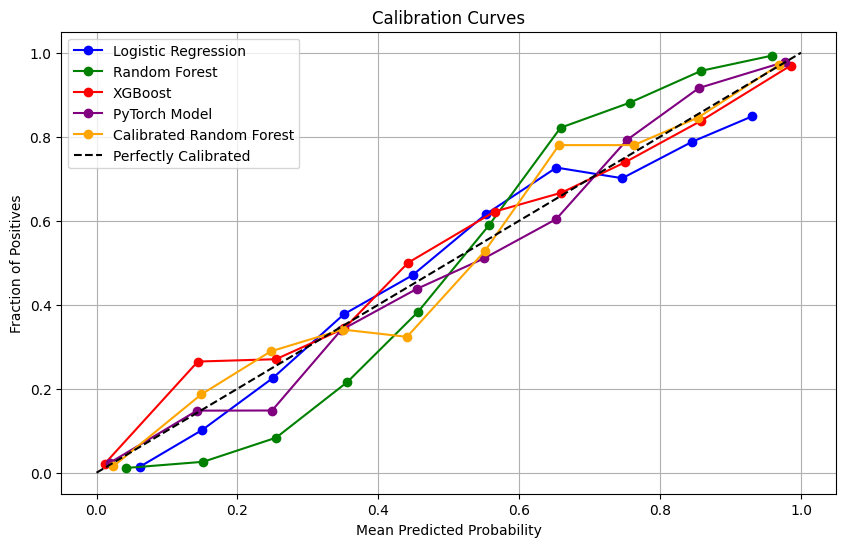

Brier Scores:
Logistic Regression: 0.1825
Random Forest: 0.0652
XGBoost: 0.0544
PyTorch Model: 0.0647
Calibrated Random Forest: 0.0556



Accuracies:
Logistic Regression: 0.7295
Random Forest: 0.9255
XGBoost: 0.9295
PyTorch Model: 0.9135
Calibrated Random Forest: 0.9290


In [212]:
logistic_prediction_probs = logistic_model.predict_proba(X_test)[:, 1]
random_forest_prediction_probs = random_forest_model.predict_proba(X_test)[:, 1]
xgboost_prediction_probs = xgboost_model.predict_proba(X_test)[:, 1]
pytorch_prediction_probs = torch_predict(pytorch_model, X_test)
calibrated_rf_prediction_probs = calibrated_rf_model.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, 
                       logistic_prediction_probs, 
                       random_forest_prediction_probs, 
                       xgboost_prediction_probs, 
                       pytorch_prediction_probs,
                       calibrated_rf_prediction_probs)

print_brier_scores(y_test, 
                 logistic_prediction_probs, 
                 random_forest_prediction_probs, 
                 xgboost_prediction_probs, 
                 pytorch_prediction_probs,
                 calibrated_rf_prediction_probs)

logistic_prediction_labels = logistic_model.predict(X_test)
random_forest_prediction_labels = random_forest_model.predict(X_test)
xgboost_prediction_labels = xgboost_model.predict(X_test)
pytorch_prediction_labels = (pytorch_prediction_probs > 0.5).astype(int)
calibrated_rf_prediction_labels = calibrated_rf_model.predict(X_test)
print('\n\n')
print_accuracies(y_test, 
                 logistic_prediction_labels, 
                 random_forest_prediction_labels, 
                 xgboost_prediction_labels, 
                 pytorch_prediction_labels,
                 calibrated_rf_prediction_labels)


The Logistic Regression has the lowest brier score, but seemingly looks one of the best on the curve. Why is that?

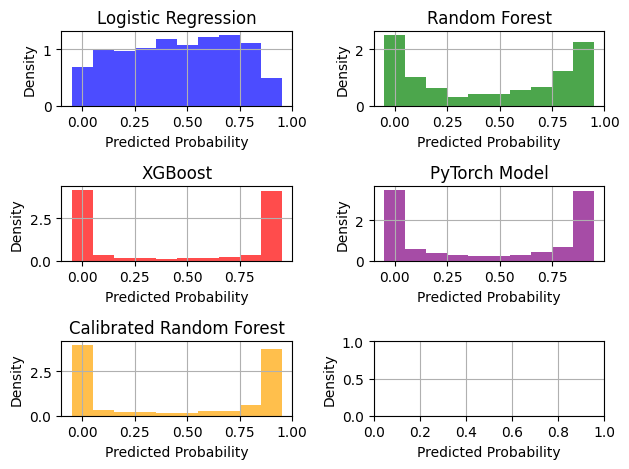

In [213]:
log_hist = np.histogram(logistic_prediction_probs, bins=10, range=(0, 1), density=True)
rf_hist = np.histogram(random_forest_prediction_probs, bins=10, range=(0, 1), density=True)
xgb_hist = np.histogram(xgboost_prediction_probs, bins=10, range=(0, 1), density=True)
pytorch_hist = np.histogram(pytorch_prediction_probs, bins=10, range=(0, 1), density=True)
calibrated_rf_hist = np.histogram(calibrated_rf_prediction_probs, bins=10, range=(0, 1), density=True)

fig, axs = plt.subplots(3, 2)
axs[0, 0].bar(log_hist[1][:-1], log_hist[0], width=0.1, color='blue', alpha=0.7)
axs[0, 0].set_title('Logistic Regression')
axs[0, 1].bar(rf_hist[1][:-1], rf_hist[0], width=0.1, color='green', alpha=0.7)
axs[0, 1].set_title('Random Forest')
axs[1, 0].bar(xgb_hist[1][:-1], xgb_hist[0], width=0.1, color='red', alpha=0.7)
axs[1, 0].set_title('XGBoost')
axs[1, 1].bar(pytorch_hist[1][:-1], pytorch_hist[0], width=0.1, color='purple', alpha=0.7)
axs[1, 1].set_title('PyTorch Model')
axs[2, 0].bar(calibrated_rf_hist[1][:-1], calibrated_rf_hist[0], width=0.1, color='orange', alpha=0.7)
axs[2, 0].set_title('Calibrated Random Forest')

for ax in axs.flat:
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.grid()
plt.tight_layout()
plt.show()



Most models have the majority of their predictions at one end or another.

Let's see how the brier score would be impacted if we removed these very high confidence predictions

In [214]:
log_pred_prob = logistic_model.predict_proba(X_test)[:, 1]
rf_pred_prob = random_forest_model.predict_proba(X_test)[:, 1]
xgb_pred_prob = xgboost_model.predict_proba(X_test)[:, 1]
pytorch_pred_prob = torch_predict(pytorch_model, X_test)
calibrated_rf_pred_prob = calibrated_rf_model.predict_proba(X_test)[:, 1]

HIGH_THRESHOLD = 0.7
LOW_THRESHOLD = 0.3
non_confident_log_indices = np.argwhere((log_pred_prob <= HIGH_THRESHOLD) & (log_pred_prob >= LOW_THRESHOLD))
non_confident_rf_indices = np.argwhere((rf_pred_prob <= HIGH_THRESHOLD) & (rf_pred_prob >= LOW_THRESHOLD))
non_confident_xgb_indices = np.argwhere((xgb_pred_prob <= HIGH_THRESHOLD) & (xgb_pred_prob >= LOW_THRESHOLD))
non_confident_pytorch_indices = np.argwhere((pytorch_pred_prob <= HIGH_THRESHOLD) & (pytorch_pred_prob >= LOW_THRESHOLD))
non_confident_calibrated_rf_indices = np.argwhere((calibrated_rf_pred_prob <= HIGH_THRESHOLD) & (calibrated_rf_pred_prob >= LOW_THRESHOLD))

print("Brier scores for non-confident predictions:")
print(f"Logistic Regression: {brier_score_loss(y_test[non_confident_log_indices], log_pred_prob[non_confident_log_indices]):.4f}")
print(f"Random Forest: {brier_score_loss(y_test[non_confident_rf_indices], rf_pred_prob[non_confident_rf_indices]):.4f}")
print(f"XGBoost: {brier_score_loss(y_test[non_confident_xgb_indices], xgb_pred_prob[non_confident_xgb_indices]):.4f}")
print(f"PyTorch Model: {brier_score_loss(y_test[non_confident_pytorch_indices], pytorch_pred_prob[non_confident_pytorch_indices]):.4f}")
print(f"Calibrated Random Forest: {brier_score_loss(y_test[non_confident_calibrated_rf_indices], calibrated_rf_pred_prob[non_confident_calibrated_rf_indices]):.4f}")

Brier scores for non-confident predictions:
Logistic Regression: 0.2299
Random Forest: 0.2032
XGBoost: 0.2315
PyTorch Model: 0.2430
Calibrated Random Forest: 0.2189


It's still not the best, but it's a lot closer with the others and is no longer the worst.

Keep in mind when checking for calibration to always check the brier score.